In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.2f} x X^{b:.2f}"

In [2]:
!python build_results_dataframe.py

In [4]:
model_profile = pd.read_csv("model_profile.csv").set_index("model")
df = pd.read_csv("results.csv")
df.head()

,path,model,pretrain_dataset,downstream_dataset,epoch,total_epochs,name,gflops_total,samples_per_sec,samples_per_sec_per_gpu,global_batch_size,training_time_hours,gpus,total_steps,task,namespace,eval_type,gpu_hours,image_acc,text_acc,acc,acc1,acc5,mean_per_class_recall,image_retrieval_recall@5,text_retrieval_recall@5,name_epoch,samples_seen_scale_simple,samples_seen_scale,lr,warmup,model_simple,name_wo_model,namespace_model,model_simple_namespace,namespace_model_samples_seen_scale,name_wo_lr
0,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1/checkpoints/sugar_crepe_swap_obj_epoch_12.pt_mammut_ViT-L-14_en_generative_image_caption_selection.json,mammut_ViT-L-14,sugar,sugar_crepe/swap_obj,12,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768.0,21.438209,128.0,39062.0,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.747967,0.747967,NaN,NaN,NaN,NaN,NaN,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw112,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768.0_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1
1,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1/checkpoints/winoground_epoch_10.pt_mammut_ViT-L-14_en_generative_image_caption_selection.json,mammut_ViT-L-14,winoground,winoground,10,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768.0,21.438209,128.0,39062.0,generative_image_caption_selection,cap,log_likelihood,2744.090771,0.125,0.157500,0.052500,NaN,NaN,NaN,NaN,NaN,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw110,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768.0_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1
2,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1/checkpoints/sugar_crepe_swap_obj_epoch_1.pt_mammut_ViT-L-14_en_generative_image_caption_selection.json,mammut_ViT-L-14,sugar,sugar_crepe/swap_obj,1,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768.0,21.438209,128.0,39062.0,generative_image_caption_selection,cap,log_likelihood,2744.090771,1.000,0.666667,0.666667,NaN,NaN,NaN,NaN,NaN,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw11,1.28B,1.28B,0.0015,20000,ViT-L-14,0.0015_1.28B_32768.0_20000,mammut_ViT-L-14_cap,ViT-L-14_cap,mammut_ViT-L-14_cap_1.28B,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1
3,/p/home/jusers/cherti1/juwels/laionize/cherti1/open_clip_scaling/logs/cap_mammut/datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1/checkpoints/sugar_crepe_replace_att_epoch_9.pt_mammut_ViT-L-14_en_generative_image_caption_selection.json,mammut_ViT-L-14,sugar,sugar_crepe/replace_att,9,20,datacomp_s1.28B_bs_32768_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n32_bs256_sigFalse_consw0_cw1,2.685952e+11,16585.133257,129.571354,32768.0,21.438209,128.

In [6]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))


Number of unique models:  1376
Number of unique checkpoints:  23597
Number of downstream datasets 12


<Axes: xlabel='model_s', ylabel='samples_per_sec_per_gpu'>

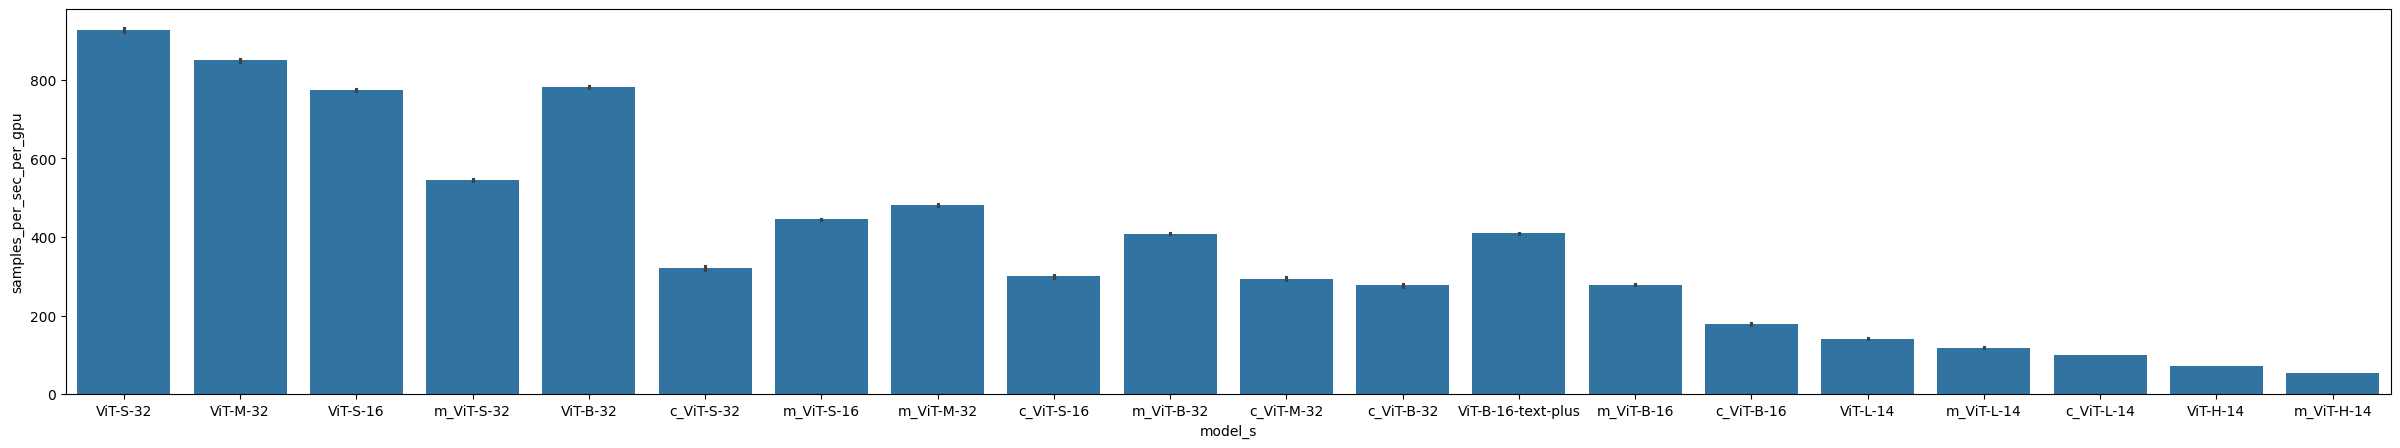

In [7]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))
archs = d.model_s.unique()
archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)
sns.barplot(x="model_s", y="samples_per_sec_per_gpu", data=d, order=archs)


In [8]:
df.columns

Index(['path', 'model', 'pretrain_dataset', 'downstream_dataset', 'epoch',
       'total_epochs', 'name', 'gflops_total', 'samples_per_sec',
       'samples_per_sec_per_gpu', 'global_batch_size', 'training_time_hours',
       'gpus', 'total_steps', 'task', 'namespace', 'eval_type', 'gpu_hours',
       'image_acc', 'text_acc', 'acc', 'acc1', 'acc5', 'mean_per_class_recall',
       'image_retrieval_recall@5', 'text_retrieval_recall@5', 'name_epoch',
       'samples_seen_scale_simple', 'samples_seen_scale', 'lr', 'warmup',
       'model_simple', 'name_wo_model', 'namespace_model',
       'model_simple_namespace', 'namespace_model_samples_seen_scale',
       'name_wo_lr'],
      dtype='object')

In [9]:
model_profile.head()

,image_size,image_width,text_width,embed_dim,mparams,image_mparams,text_mparams,gflops,image_gflops,text_gflops
model,,,,,,,,,,
ViT-S-32-alt,224,384.0,256.0,256.0,43.22,22.59,20.63,3.56,2.29,1.27
ViT-S-32,224,384.0,384.0,384.0,63.09,22.64,40.44,5.66,2.29,3.38
ViT-M-32-alt,224,512.0,384.0,384.0,80.07,39.63,40.44,7.37,3.99,3.38
ViT-M-32,224,512.0,512.0,512.0,103.12,39.69,63.43,9.95,3.99,5.96
ViT-S-16-alt,224,384.0,256.0,256.0,42.40,21.76,20.63,10.47,9.20,1.27


In [34]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
75979,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
75955,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
75843,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
75978,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
49784,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [11]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
12999,0.857724,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
6672,0.853659,datacomp_s3B_bs_32768_mammut_ViT-L-14_ep48_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n32_bs256_sigFalse_consw0_cw1,cap,45
5510,0.853659,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
12983,0.853659,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,17
11199,0.849594,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19


In [14]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
27305,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
2354,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
2240,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20
27203,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,93
27288,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97


,epoch,acc
12882,1,0.695122
13007,2,0.000000
13020,3,0.000000
12942,4,0.000000
12898,5,0.788618
13033,6,0.784553
12946,7,0.780488
13016,8,0.772358
13018,9,0.784553
13063,10,0.796748


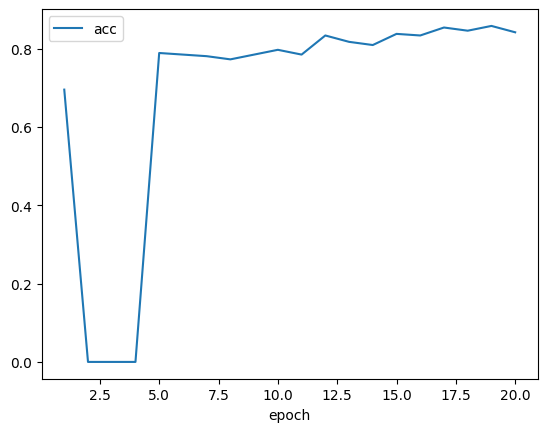

In [47]:
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"

#ds = "winoground"
#metric = "acc"
#task = "image_caption_selection"

ds = "sugar_crepe/swap_obj"
metric = "acc"
task = "generative_image_caption_selection"

#ds = "imagenet1k"
#metric = "acc1"
#task = "zeroshot_classification"

d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
d.plot(x="epoch", y=metric)
d[["epoch", metric]]

In [50]:
d = df

#ds = 'sugar_crepe/swap_obj'
#metric = "acc"

#ds = "winoground"
#metric = "acc"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"
#metric = "text_retrieval_recall@5"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,60.4M,128M,300M,640M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,,
ViT-S-32_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.305973,NaN,NaN
ViT-S-32_coca,0.005035,NaN,NaN,0.058604,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViT-S-32_mammut,0.003237,0.010930,0.030950,0.059203,0.103521,0.146859,NaN,NaN,0.271020,NaN,NaN,NaN
ViT-M-32_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.364715,NaN,NaN
ViT-M-32_mammut,0.004596,0.012888,0.032349,0.064278,0.109595,0.173094,NaN,0.273977,0.319793,NaN,NaN,NaN
ViT-S-16_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.351859,NaN,NaN
ViT-S-16_coca,NaN,NaN,NaN,NaN,0.141844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViT-S-16_mammut,0.008112,0.024457,0.048573,0.078704,0.144761,0.202486,NaN,0.289262,0.332621,NaN,NaN,NaN
ViT-B-32_cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.433064,NaN,NaN


In [24]:
d = df.copy()

#ds = 'sugar_crepe/swap_obj'
#metric = "acc"

#ds = "winoground"
#metric = "acc"

ds = "imagenet1k"
metric = "acc1"

#eval_type = "log_likelihood"
#eval_type = "similarity"
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
#d["delta"] = (d.generative_image_caption_selection - d.image_caption_selection).abs()
d["delta"] = (d.zeroshot_classification - d.generative_zeroshot_classification).abs()
d.sort_values(by="zeroshot_classification", ascending=False).head()

task,generative_zeroshot_classification,zeroshot_classification,delta
name_wo_task,,,
datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,0.688739,0.80070,0.111961
datacomp_s1.28B_bs_8192_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n8_bs256_sigFalse,0.406510,0.60556,0.199050
datacomp_s1.28B_bs_181632_gpu_352_mammut_ViT-B-32_ep20_lr0.0035_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n88_bs516_sigFalse,0.320592,0.58318,0.262588
datacomp_s640M_bs_16384_mammut_ViT-S-16_ep25_lr0.002_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse,0.332621,0.56154,0.228919
datacomp_s640M_bs_8192_mammut_ViT-S-16_ep25_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n8_bs256_sigFalse,0.326447,0.55730,0.230853


In [25]:
d.columns

Index(['generative_zeroshot_classification', 'zeroshot_classification',
       'delta'],
      dtype='object', name='task')

<Axes: xlabel='zeroshot_classification', ylabel='delta'>

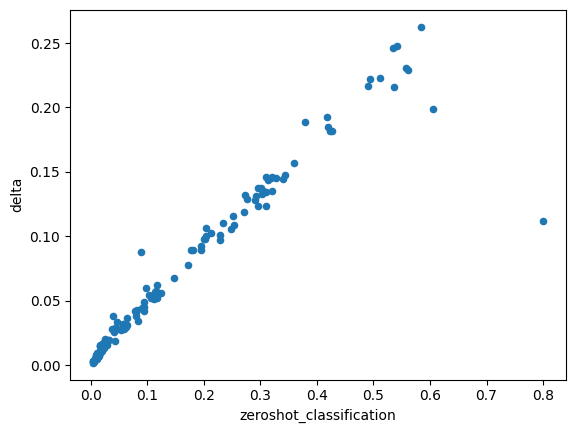

In [26]:
d.plot(x="zeroshot_classification", y="delta", kind="scatter")

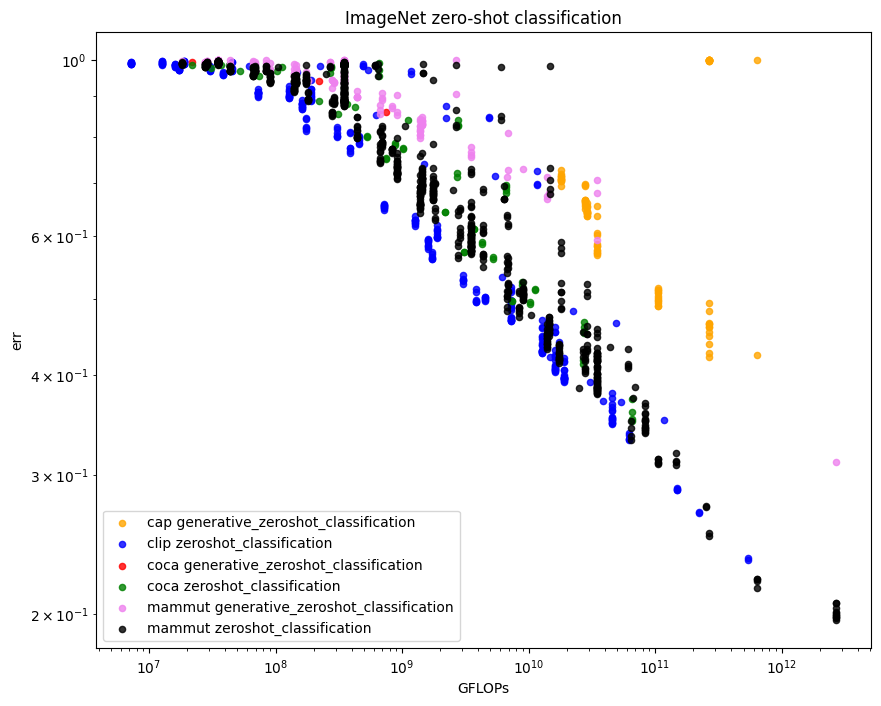

In [27]:
#ds = "sugar_crepe/swap_obj"
#metric = "acc"

#ds = "winoground"
#metric = "acc"

ds = "imagenet1k"
metric = "acc1"

#ds = "mscoco_captions"
#metric = "image_retrieval_recall@5"

D = df
D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = 1-(R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    m = X>0

    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    #coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

In [14]:
len(df)

80356